鈴木讓「統計的機械学習の数理 with Python 100問」(共立出版)

# 第3章 リサンプリング

## 3.1  クロスバリデーション

In [1]:
!pip install japanize_matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import japanize_matplotlib
import scipy
from scipy import stats
from numpy.random import randn
from sklearn.datasets import load_iris
from sklearn import linear_model

In [3]:
# Anacondaの場合は下記( import japanize_matplotlib はコメントアウト)
import matplotlib
from matplotlib import font_manager
matplotlib.rc("font", family="BIZ UDGothic")

In [4]:
def cv_linear(X, y, K):
    n = len(y)
    m = int(n / K)
    S = 0
    for j in range(K):
        test = list(range(j * m, (j + 1) * m))  # テストデータの添え字
        train = list(set(range(n)) - set(test))  # 訓練データの添え字
        beta = np.linalg.inv(X[train].T @ X[train]) @ X[train].T @ y[train]
        e = y[test] - X[test] @ beta
        S += np.linalg.norm(e) ** 2
    return S / n

In [5]:
# 線形回帰のクロスバリデーションでの評価
n = 100
p = 5
X = randn(n, p)
X = np.insert(X, 0, 1, axis=1)  # 切片項の追加

beta = randn(p + 1)
beta[[1, 2]] = 0  # 一部の係数を0に設定
y = X @ beta + randn(n)

print(cv_linear(X[:, [0, 3, 4, 5]], y, 10))

1.188747460207503


In [6]:
print(cv_linear(X, y, 10))

1.2422746229745045


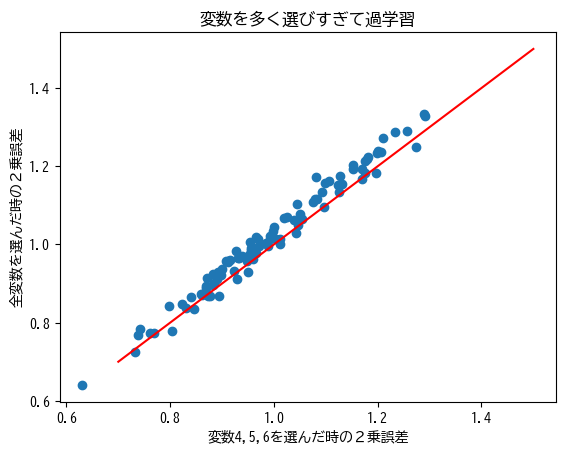

In [7]:
# 変数選択の影響のシミュレーション
U = []
V = []
for j in range(100):
    y = X @ beta + randn(n)
    U.append(cv_linear(X[:, [0, 3, 4, 5]], y, 10))
    V.append(cv_linear(X, y, 10))

x_seq = np.linspace(0.7, 1.5, 100)
y_seq = x_seq  # y = x の直線
plt.plot(x_seq, y_seq, c="red")
plt.scatter(U, V)
plt.xlabel("変数4,5,6を選んだ時の２乗誤差")
plt.ylabel("全変数を選んだ時の２乗誤差")
plt.title("変数を多く選びすぎて過学習")
plt.show()

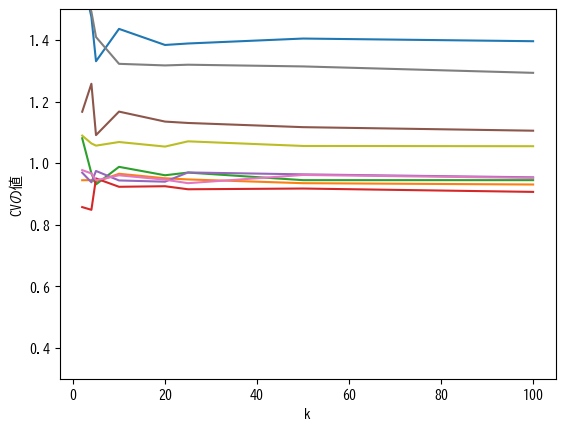

In [8]:
n = 100
p = 5

plt.ylim(0.3, 1.5)
plt.xlabel("k")
plt.ylabel("CVの値")

for j in range(2, 11):
    X = np.random.randn(n, p)
    X = np.insert(X, 0, 1, axis=1)
    beta = np.random.randn(p + 1)
    y = X @ beta + np.random.randn(n)
    U = []
    V = []
    for k in range(2, n + 1):
        if n % k == 0:
            U.append(k)
            V.append(cv_linear(X, y, k))
    plt.plot(U, V)

In [9]:
def knn_1(x, y, z, k):
    x = np.array(x)
    n, p = x.shape
    dis = np.zeros(n)
    for i in range(n):
        dis[i] = np.sum((z - x[i]) ** 2)
    S = np.argsort(dis)[:k]  # 距離が近いk個のindex
    u = np.bincount(y[S])  # 度数を数える
    m = [i for i, x in enumerate(u) if x == max(u)]  # 最頻値のindex
    # タイブレーキングの処理(最頻値が２個以上ある場合)
    while len(m) > 1:
        k -= 1
        S = S[:k]
        u = np.bincount(y[S])
        m = [i for i, x in enumerate(u) if x == max(u)]
    return m[0]

def knn(x, y, z, k):
    n = z.shape[0]
    w = np.zeros(n)
    for i in range(n):
        w[i] = knn_1(x, y, z[i], k)
    return w

In [10]:
# KNNとその評価
iris = load_iris()
x = iris.data
y = iris.target

n = x.shape[0]
index = np.random.choice(n, n, replace=False)  # 並び替える
x = x[index]
y = y[index]

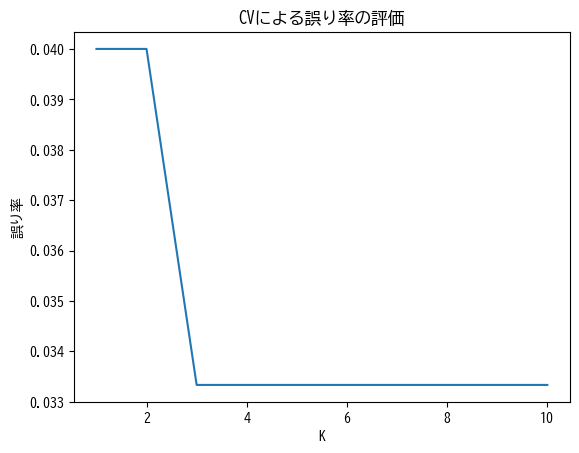

In [11]:
U = []
V = []
top_seq = list(range(0, 150, 15))

for k in range(1, 11):
    S = 0
    for top in top_seq:
        test = list(range(top, top + 15))
        train = list(set(range(150)) - set(test))
        knn_ans = knn(x[train], y[train], x[test], k=k)
        ans = y[test]
        S += np.sum(knn_ans != ans)
    S /= n
    U.append(k)
    V.append(S)

plt.plot(U, V)
plt.xlabel("K")
plt.ylabel("誤り率")
plt.title("CVによる誤り率の評価")
plt.show()

↑データによって結構かわります

## 3.2 CV fast

In [12]:
def cv_fast(X, y, k):
    n = len(y)
    m = int(n / k)  # 整数除算の正しい使用
    H = X @ np.linalg.inv(X.T @ X) @ X.T
    I = np.eye(n)  # 単位行列の生成
    e = (I - H) @ y
    S = 0
    for j in range(k):
        test = np.arange(j * m, (j + 1) * m, dtype=int)
        H_test = H[test, :][:, test]
        I_test = np.eye(len(test))  # テストセットのサイズに合わせた単位行列
        S += (e[test].T @ np.linalg.inv(I_test - H_test) @ e[test])
    return S / n

In [13]:
# データの生成
n = 1000
p = 5
beta = np.random.randn(p + 1)
X = np.random.randn(n, p)
X = np.insert(X, 0, 1, axis=1)
y = X @ beta + np.random.randn(n)

In [14]:
import time

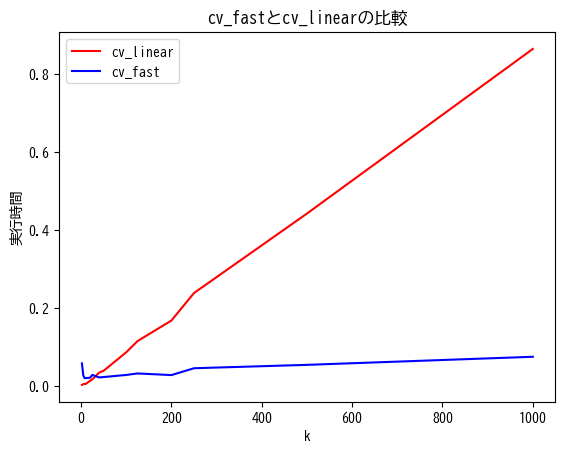

In [15]:
# 実行時間の比較
# cv_linear関数は前述のものを使用
U_l = []
V_l = []
U_f = []
V_f = []
for k in range(2, n + 1, 1):
    if n % k == 0:
        t1 = time.time()
        cv_linear(X, y, k)
        t2 = time.time()
        U_l.append(k)
        V_l.append(t2 - t1)

        t1 = time.time()
        cv_fast(X, y, k)
        t2 = time.time()
        U_f.append(k)
        V_f.append(t2 - t1)
plt.plot(U_l, V_l, c="red", label="cv_linear")
plt.plot(U_f, V_f, c="blue", label="cv_fast")
plt.legend()
plt.xlabel("k")
plt.ylabel("実行時間")
plt.title("cv_fastとcv_linearの比較")
plt.show()

## 3.3 ブートストラップ

In [16]:
def bt(df, f, r):
    m = df.shape[0]
    org = f(df, np.arange(0, m, 1))
    u = []
    for j in range(r):
        index = np.random.choice(m, m, replace=True)
        u.append(f(df, index))
    return {'original': org, 'bias': np.mean(u) - org, 'stderr': np.std(u, ddof=1)}

In [17]:
Portfolio = np.loadtxt("Portfolio.csv", delimiter=",", skiprows=1)
def func_1(data,index):
    X=data[index,0];Y=data[index,1]
    return (np.var(Y,ddof=1)-np.cov(X,Y)[0,1])/(np.var(X,ddof=1)+np.var(Y,ddof=1)-2*np.cov(X,Y)[0,1])
print(bt(Portfolio, func_1, 1000))

{'original': 0.5758320746483814, 'bias': 0.00012144294352134377, 'stderr': 0.09126002930178}


In [18]:
# crime.txtの読み込み
df = np.loadtxt("crime.txt", delimiter="\t")

# 線形回帰モデルの設定
reg = linear_model.LinearRegression()
X = df[:, 2:4]
y = df[:, 0]
reg.fit(X, y)
reg.coef_

array([11.8583308 , -5.97341169])

In [19]:
for j in range(3):
    def func_2(data, index):
        X = data[index, 2:4]
        y = data[index, 0]
        reg.fit(X, y)
        return reg.intercept_ if j == 0 else reg.coef_[j - 1]

    print(bt(df, func_2, 1000))

{'original': 621.4260363802891, 'bias': 28.226570563414157, 'stderr': 218.18753270819937}
{'original': 11.858330796711092, 'bias': -0.774499087671785, 'stderr': 3.513675713220029}
{'original': -5.973411688164964, 'bias': -0.3258931651270611, 'stderr': 3.3842577856846328}


In [20]:
import statsmodels.api as sm

In [21]:
n = X.shape[0]
X = np.insert(X, 0, 1, axis=1)
model = sm.OLS(y, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     11.30
Date:                Sun, 25 Feb 2024   Prob (F-statistic):           9.84e-05
Time:                        14:45:55   Log-Likelihood:                -344.79
No. Observations:                  50   AIC:                             695.6
Df Residuals:                      47   BIC:                             701.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        621.4260    222.685      2.791      0.0